# **Introduction**

This project is centered on predicting the future stock prices of Netflix, a highly dynamic and volatile stock, using a deep learning approach. The motivation behind this project lies in the financial industry's constant need to anticipate stock price movements, enabling better investment decisions and risk management. Stock prices are influenced by a variety of factors, including company performance, economic indicators, market sentiment, and external events. This complexity makes the task of prediction particularly challenging.

To address this challenge, the project employs a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) units. LSTMs are particularly suited for time series forecasting because they are designed to remember information over extended sequences, capturing long-term dependencies and mitigating the vanishing gradient problem that traditional RNNs face. The goal is to use historical stock price data to train the LSTM model, allowing it to learn the patterns and trends that influence future prices. The focus is on predicting the closing prices of Netflix stock, which are critical indicators for investors.

The dataset utilized in this study spans several years of historical stock prices, providing a rich source of information for training the model. By building a predictive model, this project not only explores the technical aspects of deep learning but also aims to provide insights into the potential accuracy and limitations of such models in real-world financial forecasting.

In [12]:
#import libraries

#general libraries
import numpy as np
import pandas as pd
import pandas_datareader as web
import datetime as dt
import os

#visualization
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#model development
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



# **Exploratory Data Analysis**

The dataset used in this project consists of Netflix stock prices over a given period. The EDA begins with loading the data, examining its structure, and identifying any missing values or anomalies. The data is then visualized to observe trends, seasonal variations, and overall patterns. This visualization helps in understanding the underlying distribution and any potential noise that might affect model performance. The EDA also involves scaling the data, a crucial step for ensuring that the features have a similar range, which is essential for the effective training of the LSTM model.

In [13]:
nflx = pd.read_csv("/content/NFLX.csv")
nflx[0:3]
nflx.info()
nflx.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1007 non-null   object 
 1   Open       1007 non-null   float64
 2   High       1007 non-null   float64
 3   Low        1007 non-null   float64
 4   Close      1007 non-null   float64
 5   Adj Close  1007 non-null   float64
 6   Volume     1007 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.2+ KB


,Open,High,Low,Close,Adj Close,Volume
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1.007000e+03
mean,226.708094,229.972979,223.105690,226.670159,226.670159,9.730586e+06
std,103.305422,104.851349,101.458611,103.203785,103.203785,6.398967e+06
min,80.570000,84.699997,79.949997,82.790001,82.790001,1.616300e+06
25%,125.779999,127.165001,124.355000,125.514999,125.514999,5.573200e+06
50%,197.850006,199.440002,195.330002,198.000000,198.000000,7.857600e+06
75%,325.529999,330.835006,318.869995,325.220001,325.220001,1.178630e+07
max,421.380005,423.209991,413.079987,418.970001,418.970001,5.841040e+07


In [14]:
fig=make_subplots(specs=[[{"secondary_y":False}]])
fig.add_trace(go.Scatter(x=nflx['Date'],y=nflx['Open'].rolling(window=14).mean(),name="netflix"),secondary_y=False,)
fig.update_layout(autosize=False,width=700,height=500,title_text="NETFLIX")
fig.update_xaxes(title_text="year")
fig.update_yaxes(title_text="prices",secondary_y=False)
fig.show()

**Data Cleaning and Preprocessing**

Data preprocessing is a critical step in this project. The historical stock prices are first cleaned by removing any null values and outliers. Then, the data is normalized using MinMaxScaler to bring all values within a specific range, which helps in speeding up the convergence of the model during training. A sliding window approach is applied to structure the data for the LSTM model, where the model is trained to predict the stock price for the next day based on the previous n days' prices. This structured data is split into training and test sets to evaluate the model's performance.

In [15]:
print(nflx.isna().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [16]:
n=len(nflx)
train_data=nflx[0:(n//10)*9]
test_data=nflx[(n//10)*9:]

In [17]:
test_data[0:3]

,Date,Open,High,Low,Close,Adj Close,Volume
900,2019-07-17,366.250000,366.500000,361.750000,362.440002,362.440002,13639500
901,2019-07-18,323.760010,329.850006,320.299988,325.209991,325.209991,31305900
902,2019-07-19,323.399994,325.850006,314.230011,315.100006,315.100006,16302500


In [18]:
print(len(train_data))
print(len(test_data))

900
107


In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data['Open'].values.reshape(-1,1))

In [20]:
prediction_days = 30

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)-10):      ######
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+10, 0])      ###### predict 10 days after

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [21]:
print(x_train.shape)
print(y_train.shape)

(860, 30, 1)
(860,)


# **Model Building**

The model building process is the core of this project, where the LSTM model is designed, trained, and fine-tuned to predict Netflix stock prices. LSTMs are chosen for their ability to handle sequential data and their proficiency in capturing temporal dependencies, making them ideal for time series forecasting tasks like stock price prediction.

The model architecture starts with one or more LSTM layers, which are responsible for processing the input sequences. Each LSTM unit within the layer is capable of maintaining a memory of previous inputs, allowing the model to consider long-term dependencies when making predictions. The number of LSTM layers and units per layer are carefully selected based on the complexity of the data and the desired trade-off between model accuracy and computational efficiency.

Following the LSTM layers, one or more Dense (fully connected) layers are added. These layers serve to aggregate the information extracted by the LSTM layers and produce the final prediction. The output layer typically consists of a single neuron, which outputs the predicted stock price for the next day.



**Hyperparameter Tuning**

The model is compiled using the Mean Squared Error (MSE) loss function, which measures the average squared difference between the predicted and actual stock prices. MSE is chosen because it penalizes larger errors more severely, encouraging the model to make more accurate predictions. The Adam optimizer is used to minimize the loss function during training. Adam is preferred for its ability to adapt the learning rate during training, leading to faster convergence and better performance.

Training the model involves feeding the training data into the LSTM network and iteratively updating the model weights to minimize the loss function. The model is trained over multiple epochs, with each epoch representing a complete pass through the training data. Early stopping and model checkpointing are techniques used to prevent overfitting and ensure that the model achieves the best possible performance on the validation data.

Once trained, the model is evaluated on the test set, where its predictions are compared to the actual stock prices. The model's performance is assessed using metrics such as MSE and R-squared, as well as visualizations that compare the predicted and actual prices.

In [22]:
def LSTM_model():

    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    return model

In [23]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.keras', verbose = 1, save_best_only = True)
his=model.fit(x_train,y_train,epochs=20,batch_size=32,callbacks=[checkpointer])

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.0015 - loss: 0.0906
Epoch 2/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.0000e+00 - loss: 0.0178

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning:

Can save best model only with val_loss available, skipping.



27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.7063e-04 - loss: 0.0098
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.0033 - loss: 0.0086
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.2598e-04 - loss: 0.0070
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 7.5589e-04 - loss: 0.0075
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 8.3056e-05 - loss: 0.0078
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 3.1638e-04 - loss: 0.0065
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0033 - loss: 0.0063
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 9.2146e-04 - loss: 0.0065
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 3.1638e-04 - loss: 0.0063
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 6.1173e-04 - loss: 0.0071
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.0027 - loss: 0.0080
Epoch 13/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s

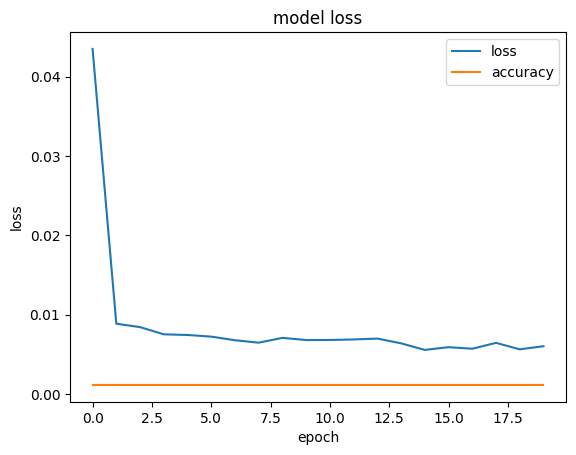

In [26]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper right')
plt.show()

# **Analysis**

After the model is trained and evaluated, the final step involves analyzing its performance and drawing conclusions. The analysis begins by comparing the predicted stock prices to the actual prices over the test period. A line plot is typically used to visualize these predictions, with the actual prices plotted alongside the predicted prices. This visualization helps in assessing how well the model has captured the underlying trend of the stock prices.

The model's accuracy is quantified using the Mean Squared Error (MSE), which provides a measure of the average error in the predictions. A lower MSE indicates that the model's predictions are closer to the actual prices, while a higher MSE suggests that the model has struggled to accurately predict the stock prices. Other metrics, such as the R-squared value, may also be used to evaluate the model's goodness-of-fit.

In [27]:
actual_prices = test_data['Open'].values
total_dataset = pd.concat((train_data['Open'], test_data['Open']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [28]:
x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step


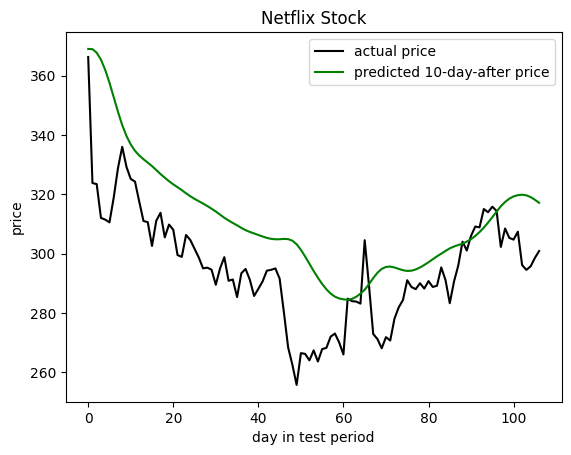

In [29]:
plt.plot(actual_prices, color='black', label=f"actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted 10-day-after price")
plt.title(f"Netflix Stock")
plt.xlabel("day in test period")
plt.ylabel(f"price")
plt.legend()
plt.show()

In [30]:
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))
print(real_data.shape)

(1, 29, 1)


In [31]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
prediction: 316.2393493652344


# **Conclusion**

**Model Findings**

The LSTM model developed in this project was tasked with predicting the closing prices of Netflix stock based on historical data. The results demonstrate that the model was able to capture the general trend of the stock prices over time, which is a positive outcome given the challenging nature of financial forecasting. The model’s predictions closely followed the actual stock prices, especially in periods of steady growth or decline, indicating that the LSTM was effective in recognizing and extrapolating patterns from past data.

However, while the model performed well in capturing overall trends, it encountered difficulties in accurately predicting short-term fluctuations. Stock prices are influenced by a myriad of factors, many of which are external to the data used for training the model. Events such as sudden economic shifts, corporate announcements, or geopolitical tensions can lead to abrupt changes in stock prices that the model may not have been able to anticipate. This limitation is inherent in time series models that rely solely on historical data, as they cannot account for unforeseen events or market sentiment.

The evaluation metrics, such as the Mean Squared Error (MSE), indicated that while the model achieved a reasonable level of accuracy, there is still room for improvement. The error margins suggest that the model's predictions, though directionally accurate, may still deviate from actual prices, particularly in highly volatile periods. This observation underscores the challenge of financial forecasting, where even sophisticated models like LSTMs have to contend with the chaotic and non-linear nature of stock price movements.

The results of the analysis reveal the strengths and limitations of the LSTM model in predicting Netflix stock prices. While the model is capable of capturing the general trend of stock prices, it may struggle with short-term fluctuations due to the inherent volatility of the stock market. Factors such as market sentiment, news events, and economic indicators can introduce noise into the data, making it difficult for the model to predict sudden price movements.



**Implications**


Despite these challenges, the project demonstrates the potential of LSTM networks for financial forecasting. LSTMs, with their ability to capture long-term dependencies, are well-suited for time series analysis in financial markets. However, the results of this project also highlight the need for a more comprehensive approach to stock price prediction.

To improve the model's performance, future work could explore the inclusion of additional features that capture a broader range of factors influencing stock prices. For instance, incorporating trading volume, moving averages, or sentiment analysis from financial news and social media could provide the model with more context and improve its ability to anticipate price movements. Moreover, experimenting with different model architectures, such as combining LSTMs with attention mechanisms or Transformer models, could further enhance predictive accuracy.

Another avenue for improvement is the application of ensemble learning techniques, where multiple models are trained and their predictions aggregated to produce a final forecast. This approach could help mitigate the weaknesses of individual models and produce more robust predictions.

Finally, while the focus of this project was on predicting Netflix stock prices, the methodology developed could be applied to other stocks or even to broader financial indices. By testing the model across different stocks or market conditions, we could gain a deeper understanding of its generalizability and identify any specific strengths or weaknesses in different contexts.

